Step 1. Load all the libraries - 
Import required libraries for data manipulation, preprocessing, model building, evaluation, and visualization.

In [114]:
# Load all the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

Step 2. Load Housing Dataset - 
Load the housing price dataset, inspect the first few rows, and check for missing values.

In [116]:
# Load housing dataset
data = pd.read_csv('housing.csv')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


Step 3. Exploratory Data Analysis - This step involves analyzing the dataset to understand distributions, correlations, and potential outliers.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom        

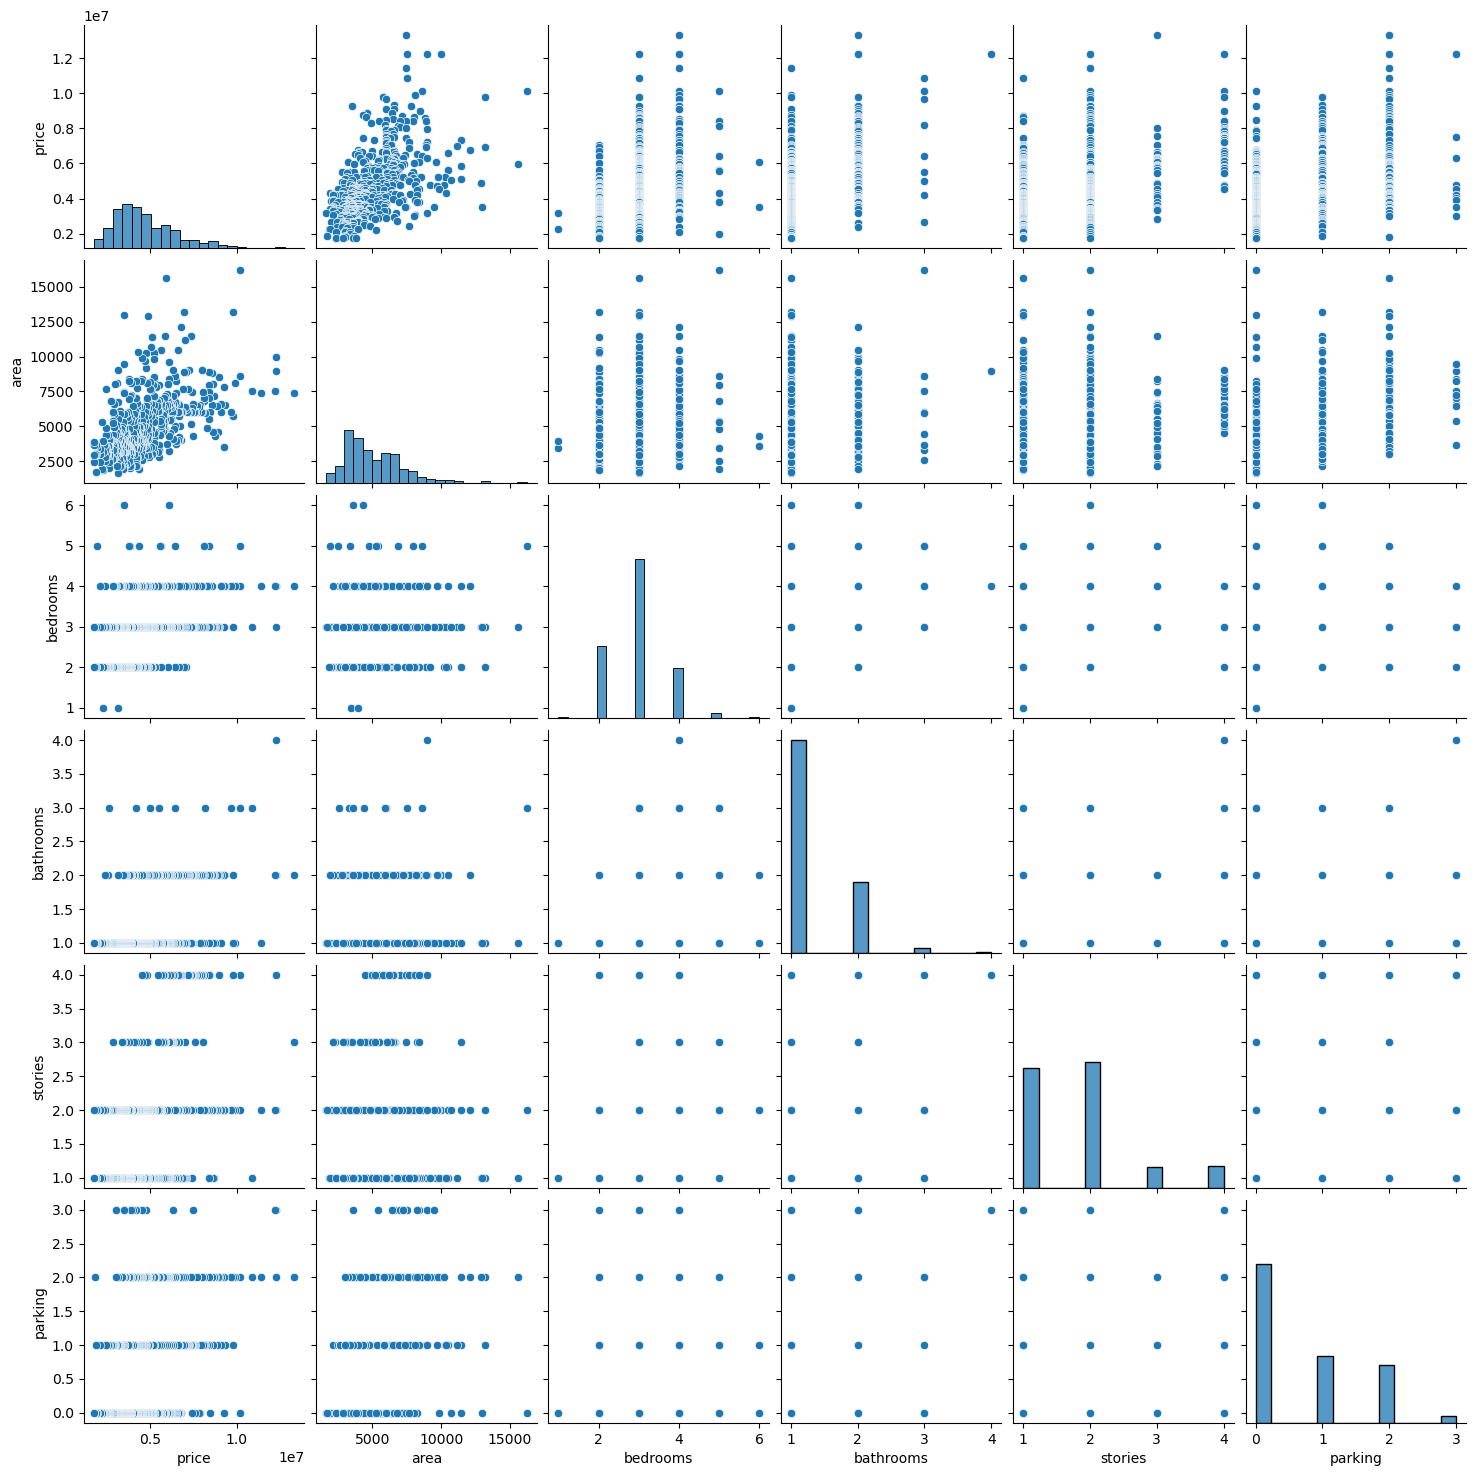

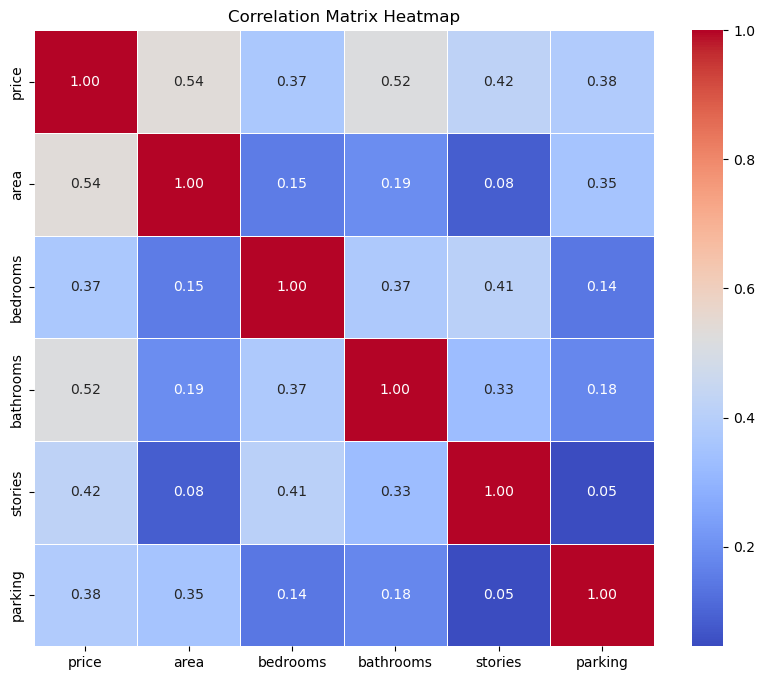

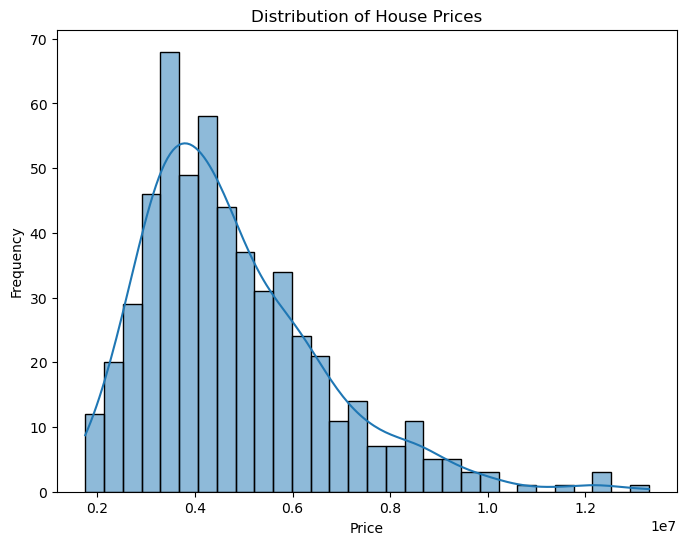

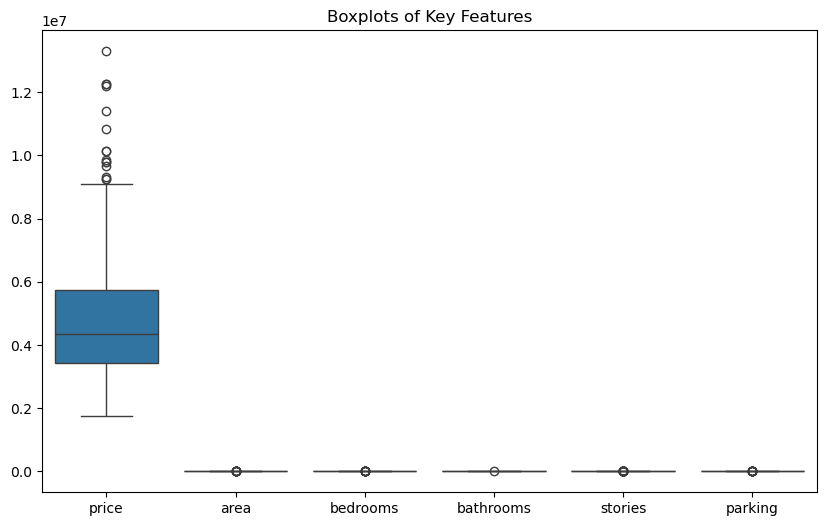

      area  bedrooms  bathrooms  stories  mainroad_yes  basement_yes  \
90    5000         3          1        2          True         False   
249   4990         4          2        2          True          True   
529   3970         3          1        2          True          True   
499   3630         3          3        2         False         False   
55    6000         3          1        2          True         False   
2     9960         3          2        2          True          True   
10   13200         3          1        2          True          True   
483   6615         3          1        2          True         False   
296   4600         3          2        2          True         False   
523   2787         4          2        2          True         False   
137   4640         4          1        2          True         False   
9     5750         3          2        4          True         False   
84    3760         3          1        2          True         F

In [118]:
# Check for null values and data types
print(data.info())  # Shows the data types, non-null counts
print(data.isnull().sum())  # Check for any missing values

# Get summary statistics for the numerical columns
print(data.describe())  # Basic statistics for numerical columns

# Visualize the pairwise relationships between numerical features
sns.pairplot(data)
plt.show()

# Visualize the correlation matrix excluding non-numeric columns
numeric_data = data.select_dtypes(include=[np.number])  # Select only numerical data
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Check the distribution of the target variable (price)
plt.figure(figsize=(8, 6))
sns.histplot(data['price'], kde=True, bins=30)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Visualize outliers for key features using boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']])
plt.title('Boxplots of Key Features')
plt.show()

# Calculate residuals
residuals = y_test - y_pred_lasso

# Set a threshold (values with absolute residuals > 1.5 million)
outlier_threshold = 1.5e6
outliers = np.where(np.abs(residuals) > outlier_threshold)

# Inspect the outliers
outlier_data = X_test.iloc[outliers]
print(outlier_data)

Step 4. Data preprocessing - Perform one-hot encoding for categorical features, split data into training and testing sets, standardize the features, and remove outliers from the training set. 

In [122]:
# Encode categorical variables using One-Hot Encoding
data_encoded = pd.get_dummies(data, drop_first=True)

# Split into features and target variable
X = data_encoded.drop('price', axis=1)  # Features (independent variables)
y = data_encoded['price']  # Target variable (dependent variable)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Reset indices of X_train_scaled and y_train to align them properly
X_train_scaled = X_train_scaled.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Identify and remove the previously identified outliers from the training set.
outliers = [90, 249, 499, 55, 2, 10, 296, 523, 137, 540, 9, 84, 185, 68, 531, 0, 11, 22, 18, 15]  # Original outlier indices
outliers_in_train = [i for i in outliers if i in X_train_scaled.index]  # Filter only training set outliers

# Remove outliers from both training features and target variable
X_train_cleaned = X_train_scaled.drop(outliers_in_train)
y_train_cleaned = y_train.drop(outliers_in_train)

# Check the preprocessed data
X_train_cleaned[:5], y_train_cleaned[:5]

(       area  bedrooms  bathrooms   stories   parking  mainroad_yes  \
 1  0.929181  0.055271   1.539173 -0.912499  2.709987      0.407155   
 3 -1.155492  0.055271  -0.557950  0.254215 -0.803059      0.407155   
 4 -0.637730  0.055271  -0.557950  0.254215 -0.803059      0.407155   
 5 -0.065467  0.055271  -0.557950  0.254215 -0.803059      0.407155   
 6 -0.592313  0.055271  -0.557950  0.254215 -0.803059      0.407155   
 
    guestroom_yes  basement_yes  hotwaterheating_yes  airconditioning_yes  \
 1      -0.466773      1.339728            -0.230521             1.501243   
 3      -0.466773      1.339728            -0.230521            -0.666115   
 4      -0.466773     -0.746420            -0.230521            -0.666115   
 5      -0.466773      1.339728            -0.230521            -0.666115   
 6      -0.466773     -0.746420            -0.230521            -0.666115   
 
    prefarea_yes  furnishingstatus_semi-furnished  furnishingstatus_unfurnished  
 1     -0.552620          

Step 5 - Model Selection and Train Dataset

Step 5.1 -  Train with Lasso Regression Model with Hyperparameter Tuning - Use Lasso regression to train the model on the cleaned training set with hyperparameter tuning.

In [124]:
# Define the hyperparameter grid for Lasso
lasso_params = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'max_iter': [1000, 5000, 10000]
}

# Initialize Lasso model
lasso = Lasso()

# Train the Lasso model using GridSearchCV for hyperparameter tuning
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train_scaled, y_train)

# Evaluate the best Lasso model
best_lasso = lasso_grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_scaled)

lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_r2 = best_lasso.score(X_test_scaled, y_test)

print(f'Best Lasso RMSE: {lasso_rmse}')
print(f'Best Lasso R-squared: {lasso_r2}')
print(f'Best Parameters: {lasso_grid.best_params_}')

Best Lasso RMSE: 1325004.1756874376
Best Lasso R-squared: 0.6526636331044082
Best Parameters: {'alpha': 1000.0, 'max_iter': 1000}


Step 5.2 - Train Model with Ridge Regression 

In [96]:
from sklearn.linear_model import Ridge

# Ridge Regression applies L2 regularization to the linear regression model
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}  # Define a grid of alpha values to test
ridge = Ridge()  # Initialize Ridge model
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')  # Use GridSearchCV to find the best alpha
ridge_grid.fit(X_train_scaled, y_train)  # Fit the model on training data

# Get the best Ridge model and evaluate it
best_ridge = ridge_grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))  # Calculate RMSE
ridge_r2 = best_ridge.score(X_test_scaled, y_test)  # Calculate R-squared

print(f'Best Ridge RMSE: {ridge_rmse}')
print(f'Best Ridge R-squared: {ridge_r2}')

Best Ridge RMSE: 1369004.8714194084
Best Ridge R-squared: 0.6292119316533709


Step 5.3 - Train Model with Elastic Regression

In [98]:
from sklearn.linear_model import ElasticNet

# Train ElasticNet with both L1 and L2 regularization
elasticnet_params = {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]}  # Define a grid for alpha and l1_ratio
elasticnet = ElasticNet()  # Initialize ElasticNet model
elasticnet_grid = GridSearchCV(elasticnet, elasticnet_params, cv=5, scoring='neg_mean_squared_error')  # Use GridSearchCV
elasticnet_grid.fit(X_train_scaled, y_train)  # Fit the model

# Get the best ElasticNet model and evaluate it
best_elasticnet = elasticnet_grid.best_estimator_
y_pred_elasticnet = best_elasticnet.predict(X_test_scaled)
elasticnet_rmse = np.sqrt(mean_squared_error(y_test, y_pred_elasticnet))  # Calculate RMSE
elasticnet_r2 = best_elasticnet.score(X_test_scaled, y_test)  # Calculate R-squared

print(f'Best ElasticNet RMSE: {elasticnet_rmse}')
print(f'Best ElasticNet R-squared: {elasticnet_r2}')

Best ElasticNet RMSE: 1372756.9009740746
Best ElasticNet R-squared: 0.6271767099232379


Step 5.4 - Train with OLS

In [100]:
import statsmodels.api as sm

# Add intercept term to the features
X_train_ols = sm.add_constant(X_train_scaled)
X_test_ols = sm.add_constant(X_test_scaled)

# Fit the OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit() 

# Predict and evaluate the OLS model
y_pred_ols = ols_model.predict(X_test_ols)
ols_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ols))  # Calculate RMSE
ols_r2 = ols_model.rsquared  

# Print the summary
print(ols_model.summary())

# Print the results
print(f'OLS RMSE: {ols_rmse}')
print(f'OLS R-squared: {ols_r2}')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     87.66
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           9.37e-97
Time:                        16:14:05   Log-Likelihood:                -6643.7
No. Observations:                 436   AIC:                         1.331e+04
Df Residuals:                     425   BIC:                         1.335e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Step 5.5 - Train with Gamma GLM

In [102]:
import statsmodels.formula.api as smf

# Gamma GLM with Log link
gamma_glm = smf.glm(formula='price ~ area + bedrooms + bathrooms + stories', 
                    data=data_encoded, 
                    family=sm.families.Gamma(link=sm.families.links.Log()))

gamma_glm_fit = gamma_glm.fit()

# Summary and performance
print(gamma_glm_fit.summary())

# Predict on the test set
y_pred_gamma_glm = gamma_glm_fit.predict(X_test_scaled)

# Calculate RMSE
gamma_glm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gamma_glm))
print(f'Gamma GLM RMSE: {gamma_glm_rmse}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                  545
Model:                            GLM   Df Residuals:                      540
Model Family:                   Gamma   Df Model:                            4
Link Function:                    Log   Scale:                        0.066380
Method:                          IRLS   Log-Likelihood:                -8375.2
Date:                Wed, 16 Oct 2024   Deviance:                       35.601
Time:                        16:14:09   Pearson chi2:                     35.8
No. Iterations:                    12   Pseudo R-squ. (CS):             0.6771
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.3043      0.051    281.433      0.0

Step 5.6 - Train with Random Forest Regressor

In [104]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_scaled)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = rf_model.score(X_test_scaled, y_test)

# Print the results
print(f'Random Forest RMSE: {rf_rmse}')
print(f'Random Forest R-squared: {rf_r2}')
print("Feature Importances:", rf_model.feature_importances_)

Random Forest RMSE: 1469219.5212318872
Random Forest R-squared: 0.572939756228837
Feature Importances: [0.50926143 0.05583765 0.1551672  0.06625548 0.01299827 0.03942472
 0.01919231 0.0696494  0.03300785 0.03920568]


Step 5.7 - Train with XGBoost Regressor

In [106]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test_scaled)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = xgb_model.score(X_test_scaled, y_test)

# Print the Results
print(f'XGBoost RMSE: {xgb_rmse}')
print(f'XGBoost R-squared: {xgb_r2}')
print("Feature Importances:", xgb_model.feature_importances_)

XGBoost RMSE: 1597941.5900367263
XGBoost R-squared: 0.4948299853962749
Feature Importances: [0.10068322 0.04255228 0.32982785 0.04607171 0.04376694 0.06398938
 0.08923542 0.16634157 0.05003781 0.06749383]


Step 5.8 - Train with Support Vector Regression

In [108]:
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_svr = svr_model.predict(X_test_scaled)
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))
svr_r2 = svr_model.score(X_test_scaled, y_test)

print(f'SVR RMSE: {svr_rmse}')
print(f'SVR R-squared: {svr_r2}')

SVR RMSE: 2359647.7394666295
SVR R-squared: -0.1015649566607495


Step 5.9 - Model Comparison

In [110]:
# Creating a DataFrame to compare the performance of the models
model_performance = pd.DataFrame({
    'Model': ['Lasso', 'Ridge', 'ElasticNet', 'OLS', 'Gamma GLM', 'Random Forest', 'XGBoost', 'SVR'],
    'RMSE': [lasso_rmse, ridge_rmse, elasticnet_rmse, ols_rmse, gamma_glm_rmse, rf_rmse, xgb_rmse, svr_rmse],
    'R-squared': [lasso_r2, ridge_r2, elasticnet_r2, ols_r2, None, rf_r2, xgb_r2, svr_r2]
})

# Display the updated comparison table
print(model_performance)

           Model          RMSE  R-squared
0          Lasso  1.366184e+06   0.630739
1          Ridge  1.369005e+06   0.629212
2     ElasticNet  1.372757e+06   0.627177
3            OLS  1.366184e+06   0.673483
4      Gamma GLM  3.720239e+06        NaN
5  Random Forest  1.469220e+06   0.572940
6        XGBoost  1.597942e+06   0.494830
7            SVR  2.359648e+06  -0.101565


Step 6. Model Interpretation and Feature Importance - Examine the model's coefficients to understand the importance of each feature in predicting housing prices.

In [174]:
# Examining coefficients for feature importance
feature_importance = pd.Series(best_lasso.coef_, index=X_train.columns)
print(feature_importance.sort_values(ascending=False))

bathrooms                          521602.500083
area                               519336.466898
airconditioning_yes                364907.837915
stories                            348788.165043
prefarea_yes                       266117.626798
parking                            191697.812659
basement_yes                       186512.516030
hotwaterheating_yes                148842.488315
mainroad_yes                       128139.021810
guestroom_yes                       88394.347137
bedrooms                            57040.018885
furnishingstatus_semi-furnished    -60682.877389
furnishingstatus_unfurnished      -190223.439011
dtype: float64


Step 7. Model Validation - Use 5-fold cross-validation to further evaluate the model's performance and estimate its generalization ability.

In [176]:
# Use cross-validation to access the model's performance
cv_scores = cross_val_score(best_lasso, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-Validation RMSE: {cv_rmse.mean()}')

Cross-Validation RMSE: 1021733.2493306873


Step 8. Model Visualizations - Generate visualizations to better understand the model's performance.

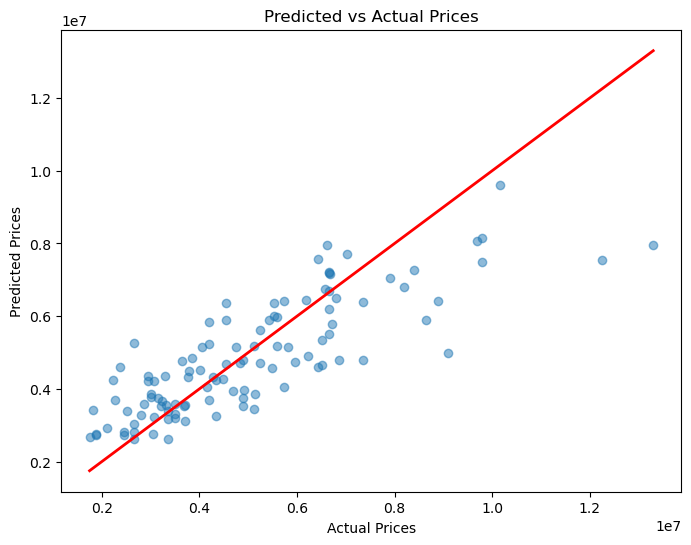

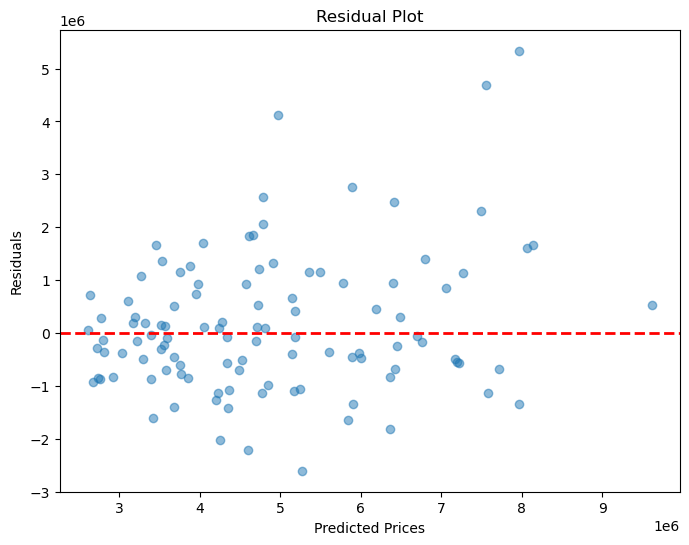

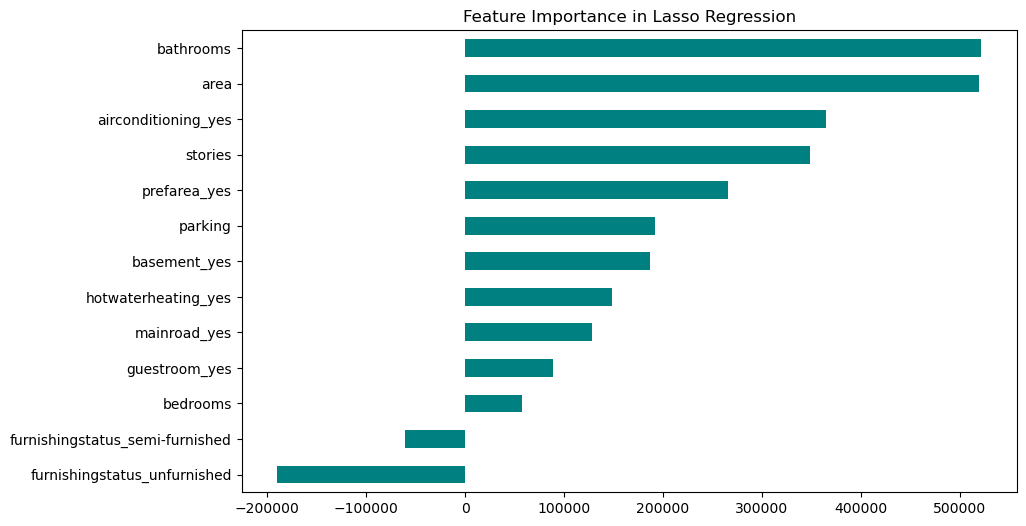

In [178]:
# Predicted vs Actual Prices Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')
plt.show()

# Residual Plot
residuals = y_test - y_pred_lasso
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lasso, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Feature Importance Plot
plt.figure(figsize=(10, 6))
feature_importance.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance in Lasso Regression')
plt.show()

Step 9: Example Use Case - Predicting Price for a New House

In [180]:
# Example input features for a new house
new_house = pd.DataFrame({
    'area': [3000],
    'bedrooms': [3],
    'bathrooms': [2],
    'stories': [2],
    'parking': [1],
    'mainroad_yes': [1],  # Encoded as 1 for Yes
    'guestroom_yes': [0],  # Encoded as 0 for No
    'basement_yes': [0],  # Encoded as 0 for No
    'hotwaterheating_yes': [0],  # Encoded as 0 for No
    'airconditioning_yes': [1],  # Encoded as 1 for Yes
    'prefarea_yes': [1],  # Encoded as 1 for Yes
    'furnishingstatus_semi-furnished': [1],  # One-hot encoded
    'furnishingstatus_unfurnished': [0]  # One-hot encoded
}, columns=X_train.columns) 

# Scale the numerical features and convert them to a DataFrame
new_house_scaled = scaler.transform(new_house)
new_house_scaled = pd.DataFrame(new_house_scaled, columns=X_train.columns)  # Convert back to DataFrame with column names

# Predict the price using the trained Lasso model
predicted_price = best_lasso.predict(new_house_scaled)

# Output the predicted price
print(f"The predicted price for the house is: {predicted_price[0]}")

The predicted price for the house is: 6089441.979844937
